In [ ]:
pip install pymupdf4llm langchain-ollama langchain-text-splitters langchain-community faiss-cpu langgraph

### Load Document

In [115]:
import pymupdf4llm
md_text = pymupdf4llm.to_markdown("1706.03762v7.pdf")

Processing 1706.03762v7.pdf...
[                                        ] (0/1=[==                                      ] ( 1/15==[=====                                   ] ( 2/1=[========                                ] ( 3/15==[==========                              ] ( 4/15==[=============                           ] ( 5/1=[================                        ] ( 6/15==[==================                      ] ( 7/15==[=====================                   ] ( 8/1=[========================                ] ( 9/15==[==========================              ] (10/15==[=============================           ] (11/1=[================================        ] (12/15==[==================================      ] (13/15==[=====================================   ] (14/1=[========================================] (15/15]


In [116]:
print(md_text)

#### Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

## Attention Is All You Need


**Ashish Vaswani[∗]**
Google Brain
```
avaswani@google.com

```
**Llion Jones[∗]**
Google Research
```
 llion@google.com

```

**Noam Shazeer[∗]**
Google Brain
```
noam@google.com

```

**Aidan N. Gomez[∗†]**
University of Toronto
```
aidan@cs.toronto.edu

```

**Niki Parmar[∗]**
Google Research
```
nikip@google.com

```

**Jakob Uszkoreit[∗]**
Google Research
```
usz@google.com

```

**Łukasz Kaiser[∗]**
Google Brain
```
lukaszkaiser@google.com

```

**Illia Polosukhin[∗‡]**
```
illia.polosukhin@gmail.com

#### Abstract

```

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a ne

### Create Chunks

In [117]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
)

documents = text_splitter.create_documents([md_text])

In [118]:
documents

[Document(metadata={}, page_content='#### Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\n\n## Attention Is All You Need\n\n\n**Ashish Vaswani[∗]**\nGoogle Brain\n```\navaswani@google.com\n\n```\n**Llion Jones[∗]**\nGoogle Research\n```\n llion@google.com\n\n```\n\n**Noam Shazeer[∗]**\nGoogle Brain\n```\nnoam@google.com\n\n```\n\n**Aidan N. Gomez[∗†]**\nUniversity of Toronto\n```\naidan@cs.toronto.edu\n\n```\n\n**Niki Parmar[∗]**\nGoogle Research\n```\nnikip@google.com\n\n```\n\n**Jakob Uszkoreit[∗]**\nGoogle Research\n```\nusz@google.com\n\n```\n\n**Łukasz Kaiser[∗]**\nGoogle Brain\n```\nlukaszkaiser@google.com\n\n```\n\n**Illia Polosukhin[∗‡]**\n```\nillia.polosukhin@gmail.com\n\n#### Abstract\n\n```'),
 Document(metadata={}, page_content='The dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include a

### Create VectorStore/Retriever

In [119]:
# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = OllamaEmbeddings(
    model="nomic-embed-text",
)


vectorstore = FAISS.from_documents(documents, embedding=embedding_model)
vectorstore.save_local(folder_path = 'vectorstore') # save the vectorstore locally

In [120]:
retriever = FAISS.load_local(
    folder_path='vectorstore',
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
    ).as_retriever(search_kwargs={"k" : 5})

In [121]:
retriever.invoke("What is self-attention?")

[Document(metadata={}, page_content='Self-attention, sometimes called intra-attention is an attention mechanism relating different positions\nof a single sequence in order to compute a representation of the sequence. Self-attention has been\nused successfully in a variety of tasks including reading comprehension, abstractive summarization,\ntextual entailment and learning task-independent sentence representations [4, 27, 28, 22].\n\nEnd-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple-language question answering and\nlanguage modeling tasks [34].\n\nTo the best of our knowledge, however, the Transformer is the first transduction model relying\nentirely on self-attention to compute representations of its input and output without using sequencealigned RNNs or convolution. In the following sections, we will describe the Transformer, motivate\nself-attention and discuss its advantages ove

In [122]:
from langchain.tools import BaseTool

class ArticleInformation(BaseTool):
    name: str = "ArticleInformation"
    description: str = "This tool is used to answer questions about the 'Attention is All You Need' article. The input is the original user question"
    
    def _run(self, question):
        retrieved_documents = retriever.invoke(question)
        return [document.page_content for document in retrieved_documents]

### Develop Chatbot workflow (langgraph)

Tools

In [123]:
tools = [ArticleInformation()]
tools_by_name = {tool.name: tool for tool in tools}

AgentState

In [124]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

System Prompt

In [125]:
from langchain_core.messages import SystemMessage

system_prompt =  SystemMessage("""You are a research assistant who answers questions the best it can, according to the contexts given to you. 
  
Your final answer should be as complete as possible, considering the results of the tools you used.
Do not oversimplify or summarize the answer.

If you are unsure about what tool to use or how to correct an error, you should ask the user for help.""")

Nodes

In [126]:
from typing import Union, Literal
from langchain_ollama import ChatOllama # you can use other chat models from langchain. they need, however, to have function call capabilities (https://python.langchain.com/docs/integrations/chat/)
from langchain_core.messages import ToolMessage, HumanMessage
import json


# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
def call_llm(state: AgentState) -> dict[str, Union[list, bool]]:
        """
        Calls the LLM model.
        
        Parameters
        ----------
        state : AgentState
            The state of the agent.
            
        Returns
        -------
        dict[str, Union[list, bool]]
            The updated state after calling the LLM model.
        """
        llm = ChatOllama( model="llama3.2", temperature=0) #instantiates the LLM model
        llm = llm.bind_tools([ArticleInformation()]) #binds the tools to the LLM model
        llm_response = llm.invoke(state['messages']) #calls the LLM model
        
        return {'messages': [llm_response]} #returns the updated state
    
def tool_node(state: AgentState) -> dict[str, Union[list, bool]]:
    '''
    Runs the tool requested in the last AI message (with the tool call).
    
    Parameters
    ----------
    state : AgentState
        The state of the agent.
        
    Returns
    -------
    dict[str, Union[list, bool]]
        The updated state after running the tool.
    '''
    if messages := state.get('messages', []):
        message = messages[-1]
    else:
        raise ValueError('No messages found in input state.')
    
    outputs = []
    
    # tool_call example
    # [{'name': 'ThesisInformation',
    # 'args': {'query': 'What is the...'},
    # 'id': 'call_UwQzgi1QD9uWfBP1r6CWO5ep',
    # 'type': 'tool_call'}]
    
    for tool_call in message.tool_calls:
        tool_result = tools_by_name[tool_call['name']].invoke(
            tool_call['args']
        )
        
        outputs.append(
            ToolMessage(
                content = json.dumps(tool_result),
                name = tool_call['name'],
                tool_call_id = tool_call['id']
            )
        )

        
    return {'messages': outputs}


def route_tools(state: AgentState) -> Literal['tools', '__end__']:
        '''
        To be used in the conditional_edge method when compiling the graph.
        Routes to the tool node if the last message contains a tool call.
        Otherwise, routes to the end.
        
        Parameters
        ----------
        state : ReactState
            The state of the agent.
            
        Returns
        -------
        Literal['tools', '__end__']
            The next node to route to.
        '''        
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state.get('messages', []):
            ai_message = messages[-1]
        else:
            raise ValueError(f'No messages found in input state to tool edge: {state}')
        
        if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
            return 'tools'
        return '__end__'

Compile Graph

In [127]:
from langgraph.graph import StateGraph, START

graph = StateGraph(AgentState)
graph.add_node('llm', call_llm)
graph.add_node('tools', tool_node)
graph.add_edge('tools', 'llm')
graph.add_edge(START, 'llm')
graph.add_conditional_edges('llm', route_tools, {'tools': 'tools', '__end__': '__end__'})

#compile graph
graph = graph.compile()

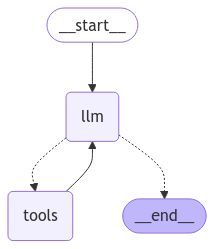

In [128]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [129]:
response = graph.invoke({'messages': [system_prompt, HumanMessage(content='What is self-attention?')]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='You are a research assistant who answers questions the best it can, according to the contexts given to you. \n  \nYour final answer should be as complete as possible, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}),
              HumanMessage(content='What is self-attention?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='You are a research assistant who answers questions the best it can, according to the contexts given to you. \n  \nYour final answer should be as complete as possible, considering the results of the tools you used.\nDo not oversimplify o

In [130]:
print(response['messages'][-1].content)

Self-attention is an attention mechanism that relates different positions of a single sequence in order to compute a representation of the sequence. It has been used successfully in various tasks such as reading comprehension, abstractive summarization, textual entailment, and learning task-independent sentence representations.

The Transformer model relies entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution. Self-attention has several advantages over models that use recurrent or convolutional layers, including:

* Total computational complexity per layer
* Amount of computation that can be parallelized

Self-attention also has the potential to yield more interpretable models, as individual attention heads clearly learn to perform different tasks and exhibit behavior related to the syntactic and semantic structure of sentences.

The training regime for self-attention models involves using a large amount of dat